In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()
ttrain=train.drop('Attrition',axis=1)

In [3]:
all_data = pd.concat((ttrain.loc[:,'Age':],
                      test.loc[:,'Age':]))

In [4]:
all_data.shape

(2098, 27)

In [5]:
all_data = pd.get_dummies(all_data)

In [6]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.Attrition

In [7]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [8]:
model_ridge = Ridge()

Text(0, 0.5, 'rmse')

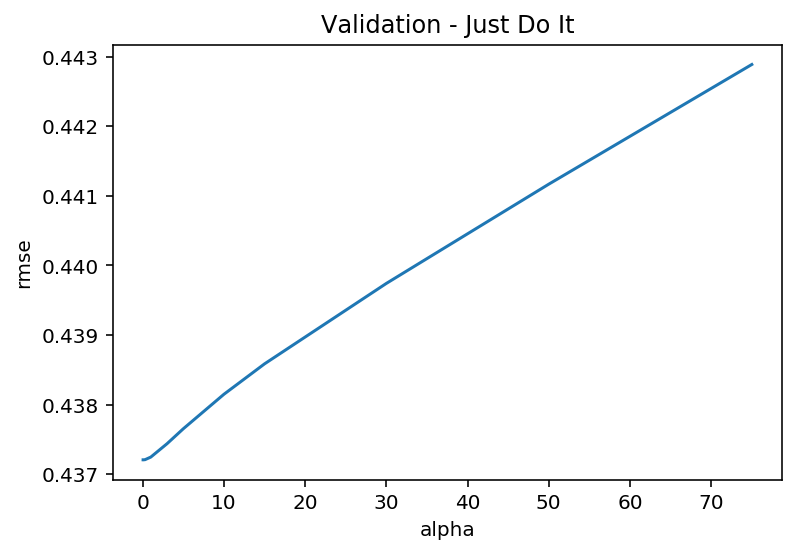

In [9]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [10]:
cv_ridge.min()

0.43720703849536885

In [11]:
model_ridge = RidgeCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [12]:
coef = pd.Series(model_ridge.coef_, index = X_train.columns)

In [13]:
print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Ridge picked 47 variables and eliminated the other 1 variables


In [14]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

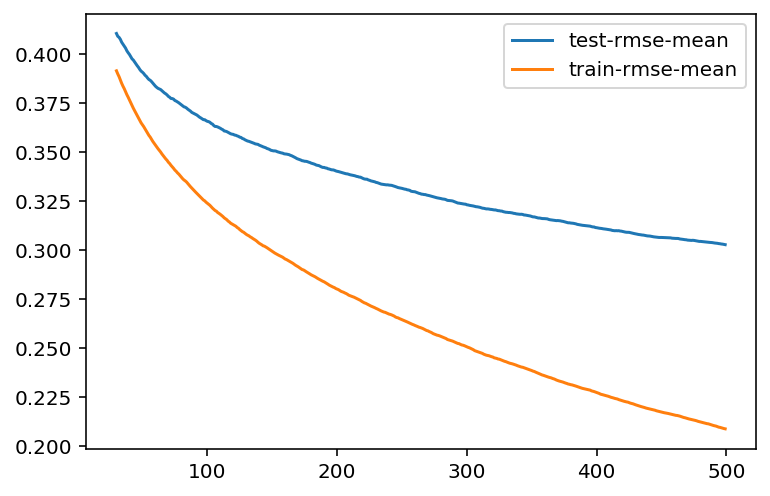

In [15]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [16]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

[15:44:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [20]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
ridge_preds = np.expm1(model_ridge.predict(X_test))

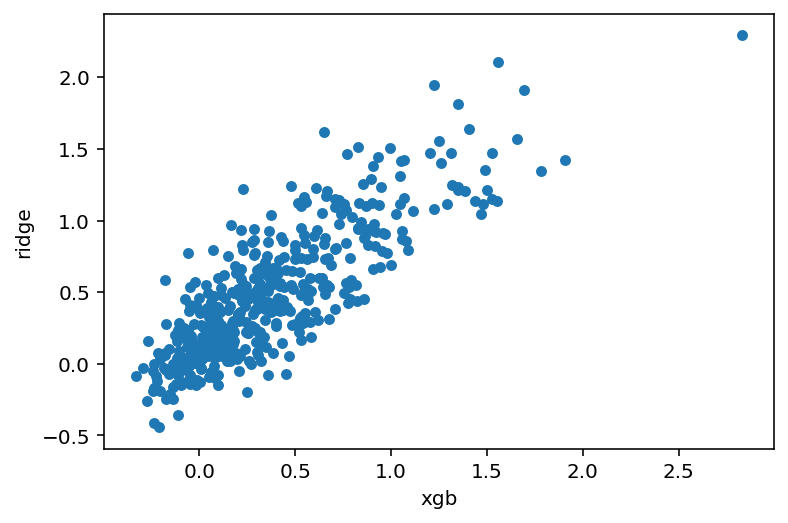

In [21]:
predictions = pd.DataFrame({"xgb":xgb_preds, "ridge":ridge_preds})
predictions.plot(x = "xgb", y = "ridge", kind = "scatter")

In [22]:
preds = 0.7*ridge_preds + 0.3*xgb_preds

In [23]:
solution = pd.DataFrame({"id":test.Id, "Attrition":preds})
solution.to_csv("ridge_xgb.csv", index = False)

In [24]:
# from sklearn.linear_model import Ridge
# from sklearn.metrics import r2_score
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# rr = Ridge(alpha=0.01)
# rr.fit(X_train, y) 
# pred_train_rr= rr.predict(X_train)
# print(np.sqrt(mean_squared_error(y,pred_train_rr)))
# print(r2_score(y, pred_train_rr))

# pred_test_rr= rr.predict(X_test)
# # print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
# # print(r2_score(y_test, pred_test_rr))

In [25]:
# rr.score(X_test,pred_test_rr)

In [26]:
# solution = pd.DataFrame({"id":test.Id, "Attrition":pred_test_rr})
# solution.to_csv("ridgeonly.csv", index = False)

In [27]:
# from sklearn.linear_model import Lasso
# model_lasso = Lasso(alpha=0.01)
# model_lasso.fit(X_train, y) 
# pred_train_lasso= model_lasso.predict(X_train)
# print(np.sqrt(mean_squared_error(y,pred_train_lasso)))
# print(r2_score(y, pred_train_lasso))

# pred_test_lasso= model_lasso.predict(X_test)
# # print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
# # print(r2_score(y_test, pred_test_lasso))